# Analysis of nested DEJMPS

In [1]:
import numpy as np
import math
import importlib as imp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn

import main_1GnB as main

---
---
## Testing Nested DEJMPS

In [2]:
n = 10

# GEN
p_gen = 0.5
F_new = 0.9
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])

# PURIF
q_purif_vec = np.linspace(0,1,10)
policy_names = ['DEJMPS', 'Double DEJMPS', 'Nested DEJMPS x1', 'Nested DEJMPS x2']
pur_after_swap = False

# NOISE
Gamma = 1/50 #1/5

# CONS
p_cons = 0.3

# Numerical
t_end = int(1e4)
randomseed = 2

In [3]:
## THEORY ##

imp.reload(main)

Fcons_theory_vec = [[] for policy in policy_names]
A_theory_vec = [[] for policy in policy_names]

for idx_policy, policy_name in enumerate(policy_names):

    purif_policy = main.policy_label_to_function(policy_name)
    
    for q_purif in q_purif_vec:
        A, Fcons = main.analytical_availability_Fcons(n, p_gen, rho_new, q_purif,
                                                      purif_policy, pur_after_swap, Gamma, p_cons)
        Fcons_theory_vec[idx_policy] += [Fcons]
        A_theory_vec[idx_policy] += [A]

theory_data = {'Fcons_avg': Fcons_theory_vec,
                'A': A_theory_vec}

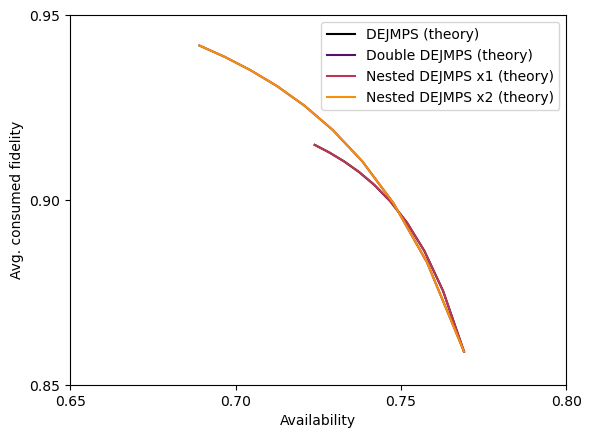

In [4]:
## PLOT ##

imp.reload(main)

main.AFplot(policy_names, sim_data=None, theory_data=theory_data, filename=None)

---
### CONCLUSIONS:
 1. Nested DEJMPS x1 and x2 seems to give the same results as DEJMPS and Double DEJMPS, as it should!
---

---
---
## Baseline: $n=10$, $p_\mathrm{gen}=0.5$, $F_\mathrm{new}=0.9$, $\Gamma=1/5$, $p_\mathrm{cons}=0.2$

In [42]:
0.25+(F_new-1/4)*np.exp(-Gamma)

0.8231115271545872

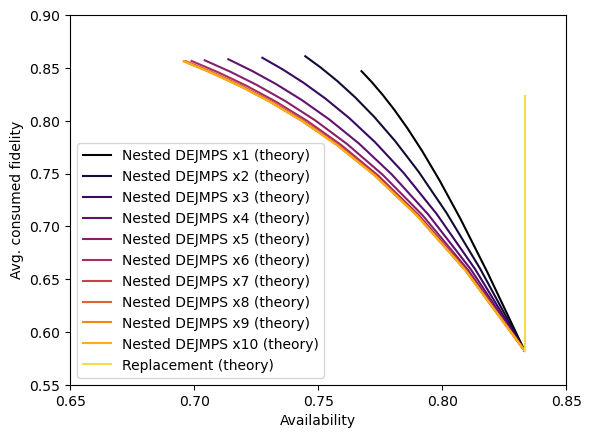

In [41]:
n = 10

# GEN
p_gen = 0.5
F_new = 0.95
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])
#rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])

# PURIF
q_purif = np.linspace(0,1,10)
policy_names = ['Nested DEJMPS x'+str(i) for i in range(1,n+1)]+['Replacement']
pur_after_swap = False

# NOISE
Gamma = 1/5

# CONS
p_cons = 0.2

# VARYING PARAMETER
varying_param = 'q_purif'

## RUN ##
imp.reload(main)
main.AFplot_theory(varying_param, n, p_gen, rho_new, q_purif, policy_names, pur_after_swap, Gamma, p_cons)

---
### CONCLUSIONS - Assumptions:
 1. Purification policy: DEJMPS, nested a number of times.
 2. $\rho_\mathrm{new}$ is Werner.

### CONCLUSIONS - Specific cases:
 1. Baseline: nesting is bad: it lowers the availability and barely increases the fidelity. Nesting twice provides the highest $F_\mathrm{cons}$.
 2. Noiseless memories: when $\Gamma$ is small (e.g., smaller than $1/50$), nesting twice is the best (even better than no nesting).
 3. Noisy memories: when $\Gamma$ is large (e.g., baseline or larger), nesting is never a good idea: it lowers the availability and barely increases the fidelity.
 4. Generation rate: varying $p_\mathrm{gen}$ from the baseline case does not change the behavior from the baseline conclusion. Larger $p_\mathrm{gen}$ yields larger differences in performance between policies, and smaller $p_\mathrm{gen}$ makes all policies perform more similarly. This makes sense since a small $p_\mathrm{gen}$ means that less links are usually available for purification and most of the nested policies do the same most of the time.
 5. $F_\mathrm{new}$: if unity, all policies perform the same. As we decrease $F_\mathrm{new}$, at some point ($F_\mathrm{new}\approx0.6$), DEJMPS becomes worse than nesting twice.
 6. Consumption: varying $p_\mathrm{cons}$ from the baseline case does not change anything from the baseline conclusion.

---
### CONCLUSIONS - General:
 1. Our analysis suggests that, if we want to apply a simple protocol in a nested way, **we should only use a subset of the newly generated links**. In all parameter regions explored, DEJMPS and Double DEJMPS form a Pareto frontier, meaning that there is no point in using more than two of the newly generated links with a Nested DEJMPS scheme.
 2. One of the main arguments against nested purification is the time it takes, since purification rounds may need to be performed sequentially. **Even assuming that purification is instantaneous, nesting as much as possible is generally not a good idea**, as discussed in the previous points. I think this is an even stronger statement against nested purification.
 
About $F_\mathrm{cons}$: 
 1. If we only care about $F_\mathrm{cons}$, there seems to be a finite optimal number of purification rounds, i.e., in general we should only use a subset of the newly generated links for nested purification to maximize $F_\mathrm{cons}$. In the previous examples, this optimal number seems to be 2.
 2. **Nesting cannot provide arbitrarily large fidelities**. In our previous paper, we showed that there is an upper bound to the fidelity that can be achieved by using 2-to-1 bilocal Clifford protocols in a nested way (including DEJMPS). We observe this in our results: $F_\mathrm{cons}$ does not converge to 1 in general.
 3. Naively, nesting a larger number of times should provide a larger $F_\mathrm{cons}$. \textit{Why do we observe that nesting twice generally maximizes $F_\mathrm{cons}$?} When nesting, the probability of success of the whole purification step decreases as we increase the number of memories used. This means that, in the limit of an infinite number of nested purifications, the probability of success will go to zero. Hence, when a consumption request arrives, it will generally find the buffered memory either empty or with a state that has not been purified. Nesting only a few times increases the probability that a consumption request finds a purified link in memory with a higher fidelity than a non-purified link. Hence, nesting a few times provides a large $F_\mathrm{cons}$ and increasing the number of nesting rounds decreases $F_\mathrm{cons}$. This reasoning can be seen in the plots below.
---

In [174]:
n = 10

# GEN
p_gen = 1
F_new = 0.9
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])

# PURIF
q_purif = 1
policy_names = ['Nested DEJMPS x2', 'Nested DEJMPS x10']
pur_after_swap = False

# NOISE
Gamma = 0

# CONS
p_cons = 0.2

# Numerical
t_end = 50
randomseed = 2

--- Nested DEJMPS x2 ---
F_cons: 0.949 (0.017)
Availab.: 0.889 (0.105)
--- Nested DEJMPS x10 ---
F_cons: 0.900 (0.000)
Availab.: 0.444 (0.166)


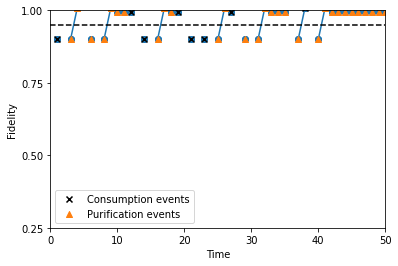

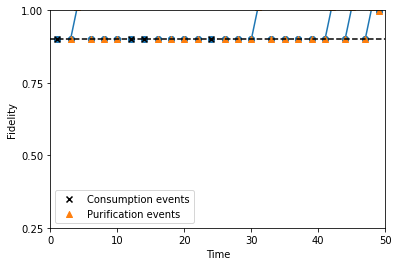

In [175]:
imp.reload(main)

for policy_name in policy_names:
    purif_policy = main.policy_label_to_function(policy_name)
    (Fcons_avg, Fcons_stderr, A_avg, A_stderr,
     buffered_fidelity_trace, cons_requests_trace, purif_events) = main.single_run_1GnB(n, p_gen, rho_new, q_purif, 
                                                                   purif_policy, pur_after_swap, Gamma,
                                                                   p_cons, t_end, randomseed)
    main.plot_run_1GnB(Fcons_avg, buffered_fidelity_trace, cons_requests_trace, purif_events, n, p_gen, rho_new,
                        q_purif, purif_policy, pur_after_swap, Gamma, p_cons, t_end, randomseed)
    print('--- %s ---'%policy_name)
    print('F_cons: %.3f (%.3f)'%(Fcons_avg, Fcons_stderr))
    print('Availab.: %.3f (%.3f)'%(A_avg, A_stderr))